## Import Important Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import scikit-learn library
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

##Import LFW Dataset

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  1288
Size of a data sample:  1850
Number of Class Labels:  7


In [3]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

##Plot the images of the dataset

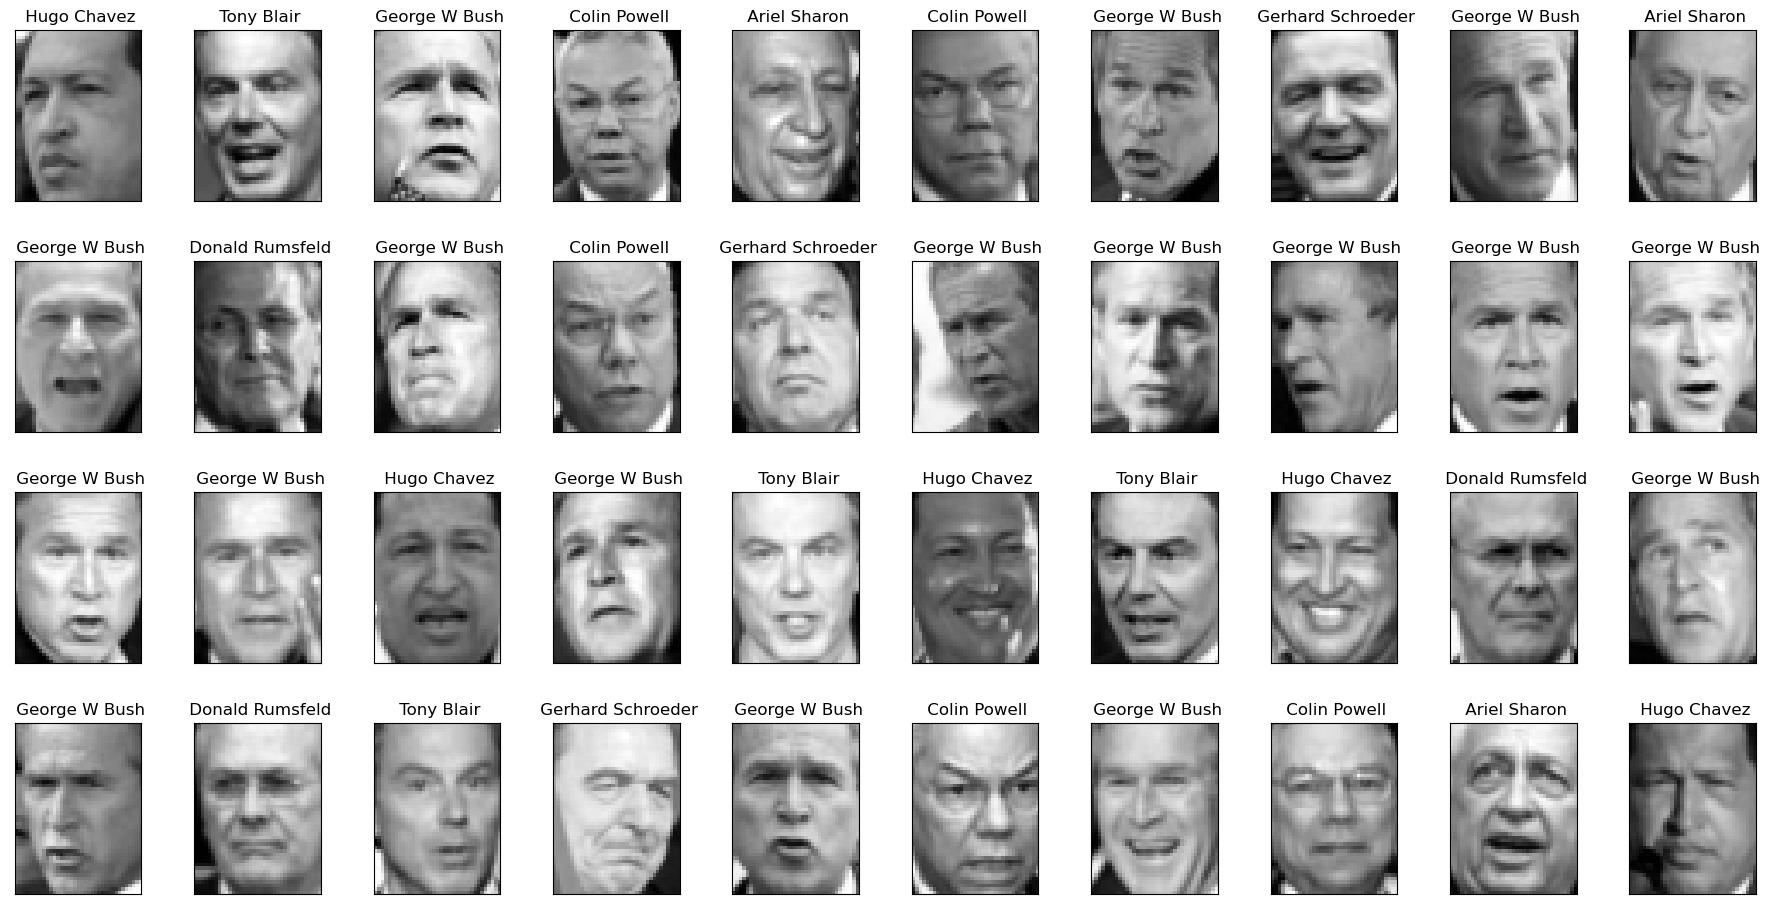

In [4]:
# Function to plot images in 3 * 4
def plot_gallery(images, titles, h, w, n_row = 4, n_col = 10):
	plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
	plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
	for i in range(n_row * n_col):
		plt.subplot(n_row, n_col, i + 1)
		plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
		plt.title(titles[i], size = 12)
		plt.xticks(())
		plt.yticks(())

# Generate true labels above the images
def true_title(Y, target_names, i):
	true_name = target_names[Y[i]]
	return ' % s' % (true_name)

true_titles = [true_title(y, target_names, i) for i in range(y.shape[0])]
plot_gallery(X, true_titles, h, w)


##Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(y_train.shape[0], y_test.shape[0])

966 322


##Define and fit PCA

In [6]:
import time
n_components = 150

pca = PCA(n_components = n_components, svd_solver ='randomized',whiten = True).fit(X_train)

##Mean Face

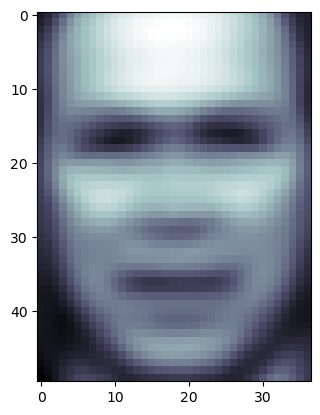

In [7]:
plt.imshow(pca.mean_.reshape((h, w)), cmap=plt.cm.bone)

##Features which discriminates the faces

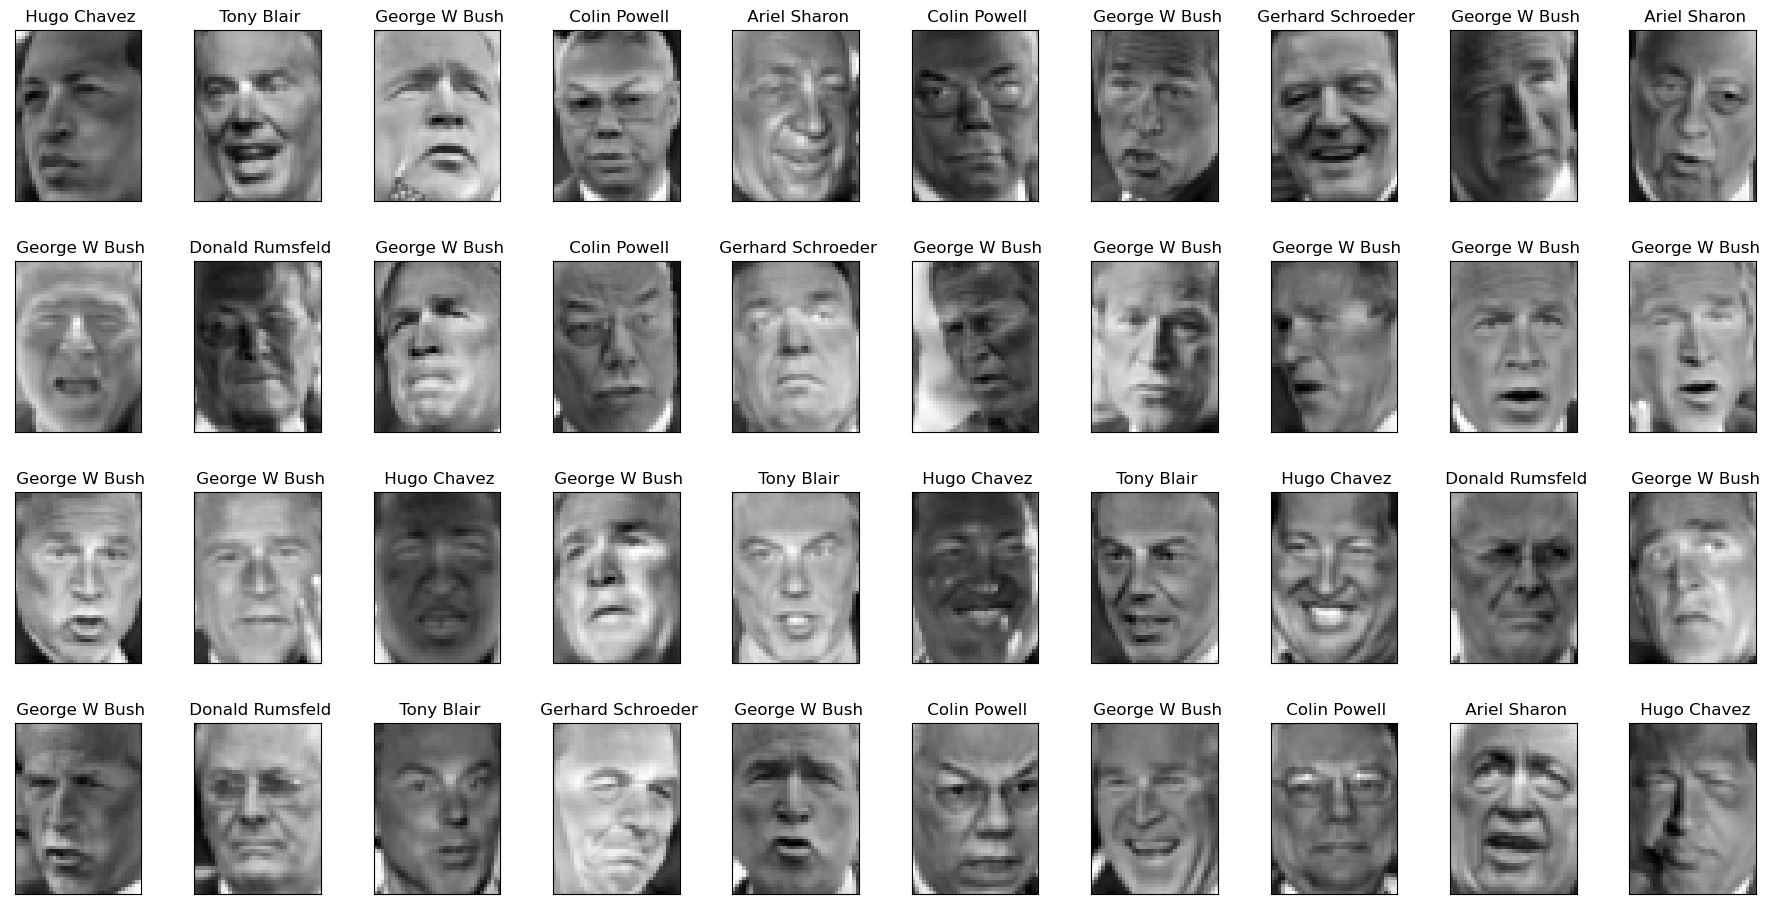

In [8]:
plot_gallery((X-pca.mean_), true_titles, h, w)

##Plot Eigenfaces along with their variences

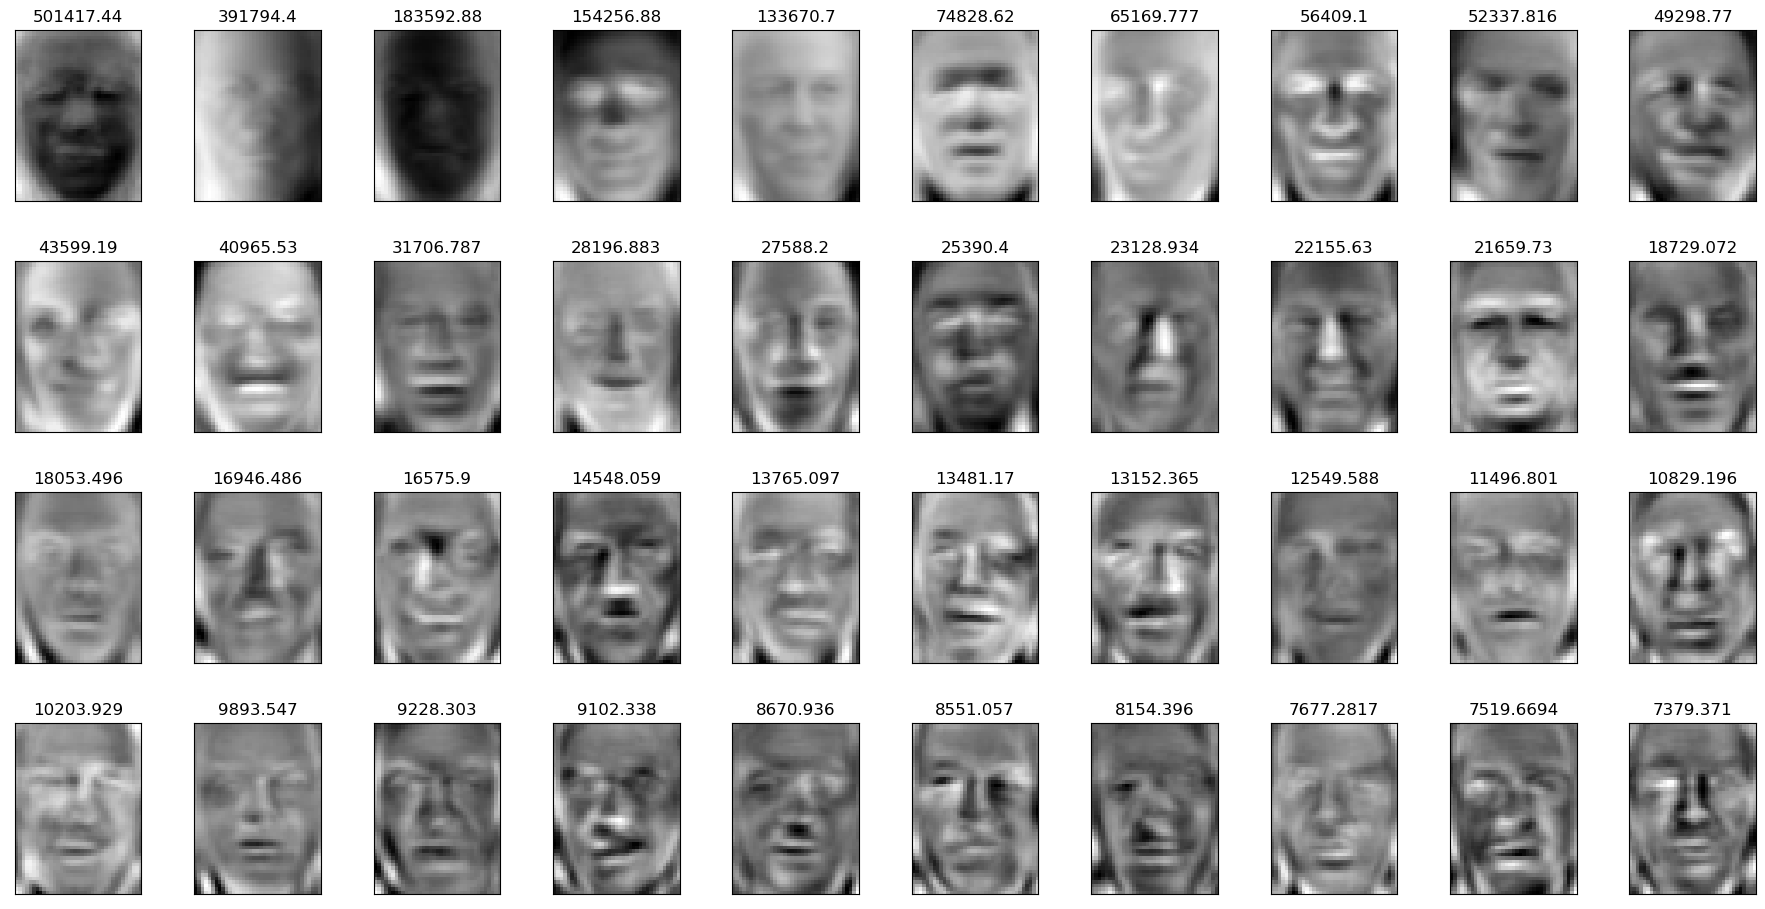

In [9]:
eigenfaces = pca.components_.reshape((n_components, h, w)) #Principal axes in feature space, representing the directions of maximum variance in the data.
eigenvarience=pca.explained_variance_
#eigenfaces.shape
plot_gallery(eigenfaces,eigenvarience,h,w)

##Plot the variences

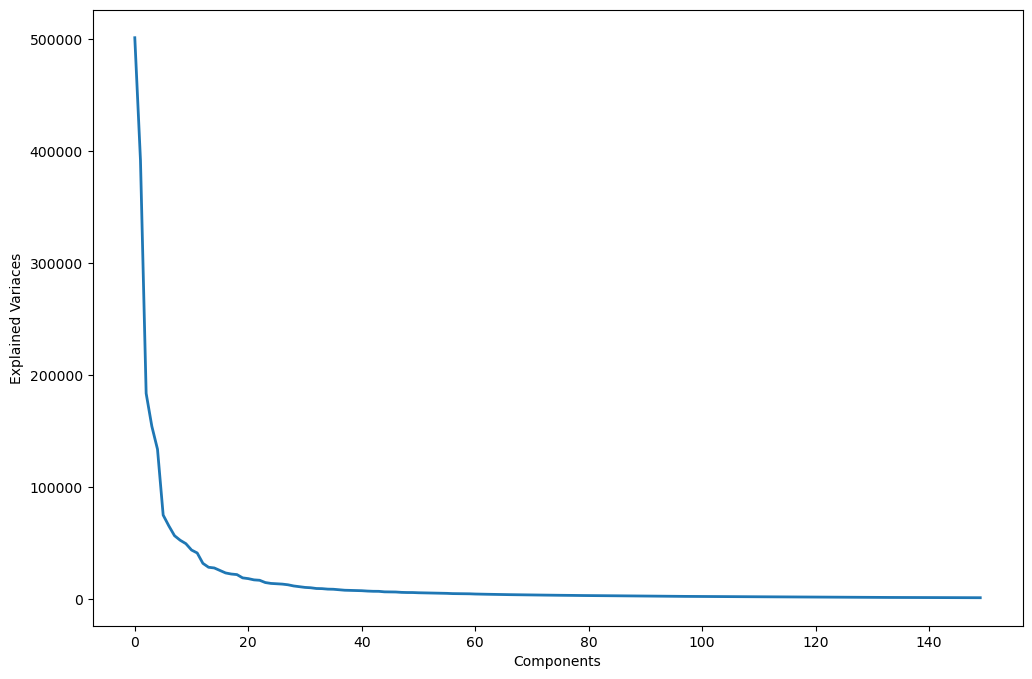

In [10]:
plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)

plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

## Transform the images into PC

In [11]:
print("Projecting the input data on the eigenfaces orthonormal basis")

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Projecting the input data on the eigenfaces orthonormal basis


## PCA Projection

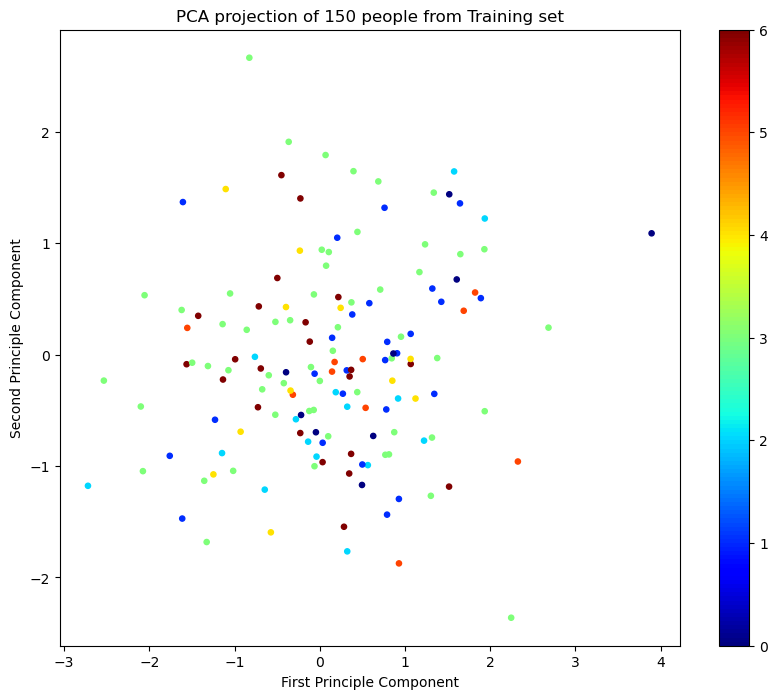

In [12]:
number_of_people=150
index_range=number_of_people
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
scatter=ax.scatter(X_train_pca[:index_range,0],
            X_train_pca[:index_range,1],
            c=y_train[:index_range],
            s=14,
           cmap=plt.get_cmap('jet', number_of_people)
          )

ax.set_xlabel("First Principle Component")
ax.set_ylabel("Second Principle Component")
ax.set_title("PCA projection of {} people from Training set".format(number_of_people))

fig.colorbar(scatter)

In [13]:
print("Sample Data point after applying PCA\n", X_train_pca[0])
print("-----------------------------------------------------")
print("Dimensions of training set = % s and Test Set = % s"%(
		X_train.shape, X_test.shape))


Sample Data point after applying PCA
 [-2.0756059  -1.0457916   2.1269386   0.03682334 -0.7575677  -0.51736534
  0.8555055   1.0519369   0.45774278  0.01348124 -0.03962922  0.6387307
  0.48166913  2.3378384   1.7784712   0.13309972 -2.2713277  -4.456915
  2.097743   -1.1379292   0.18845737 -0.33500922  1.1254466  -0.3240298
  0.14095159  1.0769508   0.75880766 -0.09977257  3.1199596   0.8837968
 -0.8933565   1.1595842   1.4306928   1.6856052   1.3434508  -1.2591203
 -0.6391186  -2.3362834  -0.01368665 -1.4638295  -0.4688692  -1.0547915
 -1.3329593   1.1365479   2.222382   -1.8016031  -0.30627576 -1.0282313
  4.773933    3.459547    1.9260367  -1.35142    -0.2590246   2.010186
 -1.0562283   0.36100775  1.1708046   0.75767356  0.90094846  0.59976846
 -0.46635506  2.0970898   1.3460962   1.9317101   5.0684686  -0.7065018
  0.60546243 -0.8986696  -0.2148507  -2.1081874  -1.6795505  -0.19967863
 -1.7440679  -3.0558107   2.056899    0.394824    0.13033561  1.2057624
 -0.7959187  -1.385931   

## Recognition Task

In [14]:
from tqdm.notebook import tqdm
import torch
# Create a device variable which will be used to shift model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

##Generate a dataloader for training data

In [15]:
dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train_pca), torch.from_numpy(y_train))

batchSize = 32
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True)

### Create a feed-forward neural network a.k.a. Multi-layer perceptron

In [16]:
class FNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    #defining layers
    self.layers = torch.nn.Sequential(*[torch.nn.Linear(150, 512),
                                        torch.nn.Linear(512, 128),
                                        torch.nn.Linear(128, 64),
                                        torch.nn.Linear(64, np.unique(y_train).shape[0])])

  def forward(self, x):

    for i in range(len(self.layers)):
      if i < len(self.layers)-1:
        x = torch.nn.Tanh()(self.layers[i](x))
      else:
        return self.layers[i](x)

### Training the Model

In [17]:
# Set the number of epochs to be used
epochs = 200

# Create the model
model = FNN().to(device)

# Define Loss
loss_function = torch.nn.CrossEntropyLoss()

# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# store average loss and accuracy
total_loss, acc = list(), list()

# training procedure
for epoch in range(epochs):
    print("\n\nEpoch:", epoch+1)

    # Each batch produces a loss, predictions and target
    batch_loss, batch_preds, batch_target = 0, list(), list()

    # For each batch
    for x, y in tqdm(dataloader_train, total=len(dataloader_train)):
        # Make sure that data is on the same device as the model
        x, y = x.to(device), y.to(device)

        # Remove all previous gradients
        optimizer.zero_grad()

        # Get predictions by performing a forward pass
        preds = model.forward(x.float())

        # Calculate error
        loss = loss_function(preds, y.to(torch.int64))

        # Calculate all the gradients for each layer
        loss.backward()

        # Finall, update the weights
        optimizer.step()

        # Save the loss
        batch_loss+= loss.item()
        # Save the predictions and target
        batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
        batch_target.extend(y.to(torch.int64).cpu().detach().numpy())
    # Calculate average loss
    total_loss.append(batch_loss/len(dataloader_train))
    # Calculate accuracy for this epoch
    acc.append(accuracy_score(batch_target, batch_preds))
    print("Loss:", total_loss[-1], "\tAcc:", acc[-1])



Epoch: 1


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.166574707915706 	Acc: 0.6055900621118012


Epoch: 2


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.4382054075118034 	Acc: 0.8871635610766045


Epoch: 3


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.239817819648212 	Acc: 0.9316770186335404


Epoch: 4


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14052711787723726 	Acc: 0.968944099378882


Epoch: 5


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.07900009724882341 	Acc: 0.9834368530020704


Epoch: 6


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0453910686736626 	Acc: 0.9927536231884058


Epoch: 7


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.026763788559624264 	Acc: 0.994824016563147


Epoch: 8


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.01728711274242209 	Acc: 0.9979296066252588


Epoch: 9


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.011031997472708744 	Acc: 0.9979296066252588


Epoch: 10


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.006431735729077651 	Acc: 1.0


Epoch: 11


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0045617060818439045 	Acc: 1.0


Epoch: 12


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.003434649454579959 	Acc: 1.0


Epoch: 13


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0028454834677939934 	Acc: 1.0


Epoch: 14


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0024745906665620786 	Acc: 1.0


Epoch: 15


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0021446749808326842 	Acc: 1.0


Epoch: 16


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0018617494103138246 	Acc: 1.0


Epoch: 17


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.001679512921855935 	Acc: 1.0


Epoch: 18


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0015103341354387662 	Acc: 1.0


Epoch: 19


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0013386428960779262 	Acc: 1.0


Epoch: 20


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0012272327608849492 	Acc: 1.0


Epoch: 21


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0011102538931393815 	Acc: 1.0


Epoch: 22


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0010229509376410034 	Acc: 1.0


Epoch: 23


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0009352482260099702 	Acc: 1.0


Epoch: 24


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0008741706992769914 	Acc: 1.0


Epoch: 25


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0008104777943733479 	Acc: 1.0


Epoch: 26


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0007666661047316607 	Acc: 1.0


Epoch: 27


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.000709037585634618 	Acc: 1.0


Epoch: 28


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0006529191624365687 	Acc: 1.0


Epoch: 29


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0006096301545884701 	Acc: 1.0


Epoch: 30


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0005776580533899007 	Acc: 1.0


Epoch: 31


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0005478909015730624 	Acc: 1.0


Epoch: 32


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0005138895095085665 	Acc: 1.0


Epoch: 33


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0004957924078729364 	Acc: 1.0


Epoch: 34


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00046296498171173996 	Acc: 1.0


Epoch: 35


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0004363403427452149 	Acc: 1.0


Epoch: 36


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0004133212252429897 	Acc: 1.0


Epoch: 37


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0003924724813024964 	Acc: 1.0


Epoch: 38


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00038090068659174346 	Acc: 1.0


Epoch: 39


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0003564140915254792 	Acc: 1.0


Epoch: 40


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0003385180527637262 	Acc: 1.0


Epoch: 41


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00032030627921959684 	Acc: 1.0


Epoch: 42


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00030784344210499717 	Acc: 1.0


Epoch: 43


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00029608686952175753 	Acc: 1.0


Epoch: 44


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0002837130795664815 	Acc: 1.0


Epoch: 45


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0002737479681532169 	Acc: 1.0


Epoch: 46


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00026127657639012943 	Acc: 1.0


Epoch: 47


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00025235961901114113 	Acc: 1.0


Epoch: 48


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00024000185141865644 	Acc: 1.0


Epoch: 49


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00023040206701074157 	Acc: 1.0


Epoch: 50


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0002253475862333641 	Acc: 1.0


Epoch: 51


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00021606384454512847 	Acc: 1.0


Epoch: 52


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00020753344259930834 	Acc: 1.0


Epoch: 53


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0001979886599714988 	Acc: 1.0


Epoch: 54


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0001911395384306689 	Acc: 1.0


Epoch: 55


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00018544148535452662 	Acc: 1.0


Epoch: 56


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00018188683456936552 	Acc: 1.0


Epoch: 57


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00017544900554405046 	Acc: 1.0


Epoch: 58


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00016824704535763651 	Acc: 1.0


Epoch: 59


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00016688384822637385 	Acc: 1.0


Epoch: 60


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00015788160512344011 	Acc: 1.0


Epoch: 61


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00015162915106855274 	Acc: 1.0


Epoch: 62


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00014516772200529943 	Acc: 1.0


Epoch: 63


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0001415094962031881 	Acc: 1.0


Epoch: 64


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00013861303417680545 	Acc: 1.0


Epoch: 65


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00013210099155736726 	Acc: 1.0


Epoch: 66


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0001289956013469266 	Acc: 1.0


Epoch: 67


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00012756253601119464 	Acc: 1.0


Epoch: 68


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00012181358596858298 	Acc: 1.0


Epoch: 69


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0001170579981267257 	Acc: 1.0


Epoch: 70


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.0001143712773139874 	Acc: 1.0


Epoch: 71


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00011329709858757504 	Acc: 1.0


Epoch: 72


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00010910497064375499 	Acc: 1.0


Epoch: 73


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00010544056849246244 	Acc: 1.0


Epoch: 74


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.00010243577508522469 	Acc: 1.0


Epoch: 75


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.998879742793619e-05 	Acc: 1.0


Epoch: 76


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.512900408393057e-05 	Acc: 1.0


Epoch: 77


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.377407156036145e-05 	Acc: 1.0


Epoch: 78


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.074670191283428e-05 	Acc: 1.0


Epoch: 79


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.929757865600198e-05 	Acc: 1.0


Epoch: 80


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.820353797355276e-05 	Acc: 1.0


Epoch: 81


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.408961319571151e-05 	Acc: 1.0


Epoch: 82


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.298055024258042e-05 	Acc: 1.0


Epoch: 83


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.162527357795156e-05 	Acc: 1.0


Epoch: 84


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 7.820478206286356e-05 	Acc: 1.0


Epoch: 85


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 7.572773533719291e-05 	Acc: 1.0


Epoch: 86


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 7.354223024806068e-05 	Acc: 1.0


Epoch: 87


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 7.14113241208965e-05 	Acc: 1.0


Epoch: 88


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 6.991402774621102e-05 	Acc: 1.0


Epoch: 89


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 6.950955773185518e-05 	Acc: 1.0


Epoch: 90


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 6.764534308815436e-05 	Acc: 1.0


Epoch: 91


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 7.905221308089582e-05 	Acc: 1.0


Epoch: 92


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 6.44257077862764e-05 	Acc: 1.0


Epoch: 93


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 6.159474439975324e-05 	Acc: 1.0


Epoch: 94


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 6.051422819690478e-05 	Acc: 1.0


Epoch: 95


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 6.009345645819145e-05 	Acc: 1.0


Epoch: 96


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 5.732217493547772e-05 	Acc: 1.0


Epoch: 97


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 5.677900234361239e-05 	Acc: 1.0


Epoch: 98


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 5.609329368340813e-05 	Acc: 1.0


Epoch: 99


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 5.3374448109553344e-05 	Acc: 1.0


Epoch: 100


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 5.2404746736189534e-05 	Acc: 1.0


Epoch: 101


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 5.1672317274478116e-05 	Acc: 1.0


Epoch: 102


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 5.0224257774384424e-05 	Acc: 1.0


Epoch: 103


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 4.9396868792339976e-05 	Acc: 1.0


Epoch: 104


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 4.827488813926691e-05 	Acc: 1.0


Epoch: 105


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 4.600680480390081e-05 	Acc: 1.0


Epoch: 106


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 4.559554814008034e-05 	Acc: 1.0


Epoch: 107


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 4.395712708614038e-05 	Acc: 1.0


Epoch: 108


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 4.341453624816026e-05 	Acc: 1.0


Epoch: 109


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 4.28661761919014e-05 	Acc: 1.0


Epoch: 110


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 4.173320637839366e-05 	Acc: 1.0


Epoch: 111


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 4.042241268888897e-05 	Acc: 1.0


Epoch: 112


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.978561606697528e-05 	Acc: 1.0


Epoch: 113


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.891473633918776e-05 	Acc: 1.0


Epoch: 114


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.792780458869886e-05 	Acc: 1.0


Epoch: 115


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.718815253617528e-05 	Acc: 1.0


Epoch: 116


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.675233963276109e-05 	Acc: 1.0


Epoch: 117


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.582379571115223e-05 	Acc: 1.0


Epoch: 118


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.557143962450115e-05 	Acc: 1.0


Epoch: 119


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.4280498444023845e-05 	Acc: 1.0


Epoch: 120


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.366089391244215e-05 	Acc: 1.0


Epoch: 121


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.2829888339385376e-05 	Acc: 1.0


Epoch: 122


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.2488250238407826e-05 	Acc: 1.0


Epoch: 123


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.184707219911469e-05 	Acc: 1.0


Epoch: 124


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.138166914962518e-05 	Acc: 1.0


Epoch: 125


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 3.0510260565337845e-05 	Acc: 1.0


Epoch: 126


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.97872686074228e-05 	Acc: 1.0


Epoch: 127


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.9605958579556882e-05 	Acc: 1.0


Epoch: 128


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.873276806044047e-05 	Acc: 1.0


Epoch: 129


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.8003489205730148e-05 	Acc: 1.0


Epoch: 130


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.7755262841134438e-05 	Acc: 1.0


Epoch: 131


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.7102422380619005e-05 	Acc: 1.0


Epoch: 132


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.65056973911405e-05 	Acc: 1.0


Epoch: 133


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.5822479015445305e-05 	Acc: 1.0


Epoch: 134


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.515768706108511e-05 	Acc: 1.0


Epoch: 135


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.7329300733512236e-05 	Acc: 1.0


Epoch: 136


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.4143036699247352e-05 	Acc: 1.0


Epoch: 137


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.438942708742557e-05 	Acc: 1.0


Epoch: 138


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.330966001482598e-05 	Acc: 1.0


Epoch: 139


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.3132452482851448e-05 	Acc: 1.0


Epoch: 140


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.2577430524594796e-05 	Acc: 1.0


Epoch: 141


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.231983454558142e-05 	Acc: 1.0


Epoch: 142


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.1640090527662616e-05 	Acc: 1.0


Epoch: 143


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.1192128095266995e-05 	Acc: 1.0


Epoch: 144


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.1312067298323756e-05 	Acc: 1.0


Epoch: 145


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 2.1024364521567364e-05 	Acc: 1.0


Epoch: 146


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.98333411624903e-05 	Acc: 1.0


Epoch: 147


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.956220333546122e-05 	Acc: 1.0


Epoch: 148


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.9181125084756905e-05 	Acc: 1.0


Epoch: 149


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.8786161461086464e-05 	Acc: 1.0


Epoch: 150


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.8757939899167526e-05 	Acc: 1.0


Epoch: 151


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.8314827361938378e-05 	Acc: 1.0


Epoch: 152


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.78512725817141e-05 	Acc: 1.0


Epoch: 153


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.7703885356651527e-05 	Acc: 1.0


Epoch: 154


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.741826145007508e-05 	Acc: 1.0


Epoch: 155


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.68172646813365e-05 	Acc: 1.0


Epoch: 156


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.6661597299154834e-05 	Acc: 1.0


Epoch: 157


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.6116921708617744e-05 	Acc: 1.0


Epoch: 158


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.5843578929038373e-05 	Acc: 1.0


Epoch: 159


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.558845340168186e-05 	Acc: 1.0


Epoch: 160


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.5249958617078523e-05 	Acc: 1.0


Epoch: 161


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.5264979640872503e-05 	Acc: 1.0


Epoch: 162


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.4853867410678387e-05 	Acc: 1.0


Epoch: 163


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.4385528556299359e-05 	Acc: 1.0


Epoch: 164


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.4188714474937203e-05 	Acc: 1.0


Epoch: 165


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.404805419541287e-05 	Acc: 1.0


Epoch: 166


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.376082884469783e-05 	Acc: 1.0


Epoch: 167


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.3668273148200129e-05 	Acc: 1.0


Epoch: 168


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.3594098046239871e-05 	Acc: 1.0


Epoch: 169


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.3068810051575589e-05 	Acc: 1.0


Epoch: 170


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.2632034448019582e-05 	Acc: 1.0


Epoch: 171


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.260787690449844e-05 	Acc: 1.0


Epoch: 172


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.2348237818983879e-05 	Acc: 1.0


Epoch: 173


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.2239206816664063e-05 	Acc: 1.0


Epoch: 174


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.1808923494343969e-05 	Acc: 1.0


Epoch: 175


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.1836199621851143e-05 	Acc: 1.0


Epoch: 176


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.1397792399469424e-05 	Acc: 1.0


Epoch: 177


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.1143070878461003e-05 	Acc: 1.0


Epoch: 178


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.0956277037621476e-05 	Acc: 1.0


Epoch: 179


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.0850241998864916e-05 	Acc: 1.0


Epoch: 180


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.0592026228550822e-05 	Acc: 1.0


Epoch: 181


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.068414852148459e-05 	Acc: 1.0


Epoch: 182


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.0448729221201163e-05 	Acc: 1.0


Epoch: 183


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.0088096044660966e-05 	Acc: 1.0


Epoch: 184


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.920690401134291e-06 	Acc: 1.0


Epoch: 185


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.731127911729874e-06 	Acc: 1.0


Epoch: 186


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.509963650001033e-06 	Acc: 1.0


Epoch: 187


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.408407564596047e-06 	Acc: 1.0


Epoch: 188


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.20886458838903e-06 	Acc: 1.0


Epoch: 189


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 9.050385723375872e-06 	Acc: 1.0


Epoch: 190


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.970176050723005e-06 	Acc: 1.0


Epoch: 191


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.844142044953543e-06 	Acc: 1.0


Epoch: 192


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.532562626515432e-06 	Acc: 1.0


Epoch: 193


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.556139149614836e-06 	Acc: 1.0


Epoch: 194


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.388562257037378e-06 	Acc: 1.0


Epoch: 195


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.147322601402148e-06 	Acc: 1.0


Epoch: 196


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.105441734627558e-06 	Acc: 1.0


Epoch: 197


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 8.104613654370862e-06 	Acc: 1.0


Epoch: 198


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 7.781930999924718e-06 	Acc: 1.0


Epoch: 199


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 7.582992096896275e-06 	Acc: 1.0


Epoch: 200


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 7.570826549072667e-06 	Acc: 1.0


### Evaluate the recognition task

In [18]:
model = model.to(device)
from sklearn.metrics import classification_report
y_pred = model(torch.from_numpy(X_test_pca).to(device))
print(classification_report(y_test, torch.argmax(y_pred,-1).detach().cpu().numpy(), target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.54      0.58        13
     Colin Powell       0.83      0.90      0.86        60
  Donald Rumsfeld       0.69      0.74      0.71        27
    George W Bush       0.91      0.88      0.90       146
Gerhard Schroeder       0.78      0.84      0.81        25
      Hugo Chavez       0.86      0.80      0.83        15
       Tony Blair       0.80      0.78      0.79        36

         accuracy                           0.84       322
        macro avg       0.79      0.78      0.78       322
     weighted avg       0.84      0.84      0.84       322



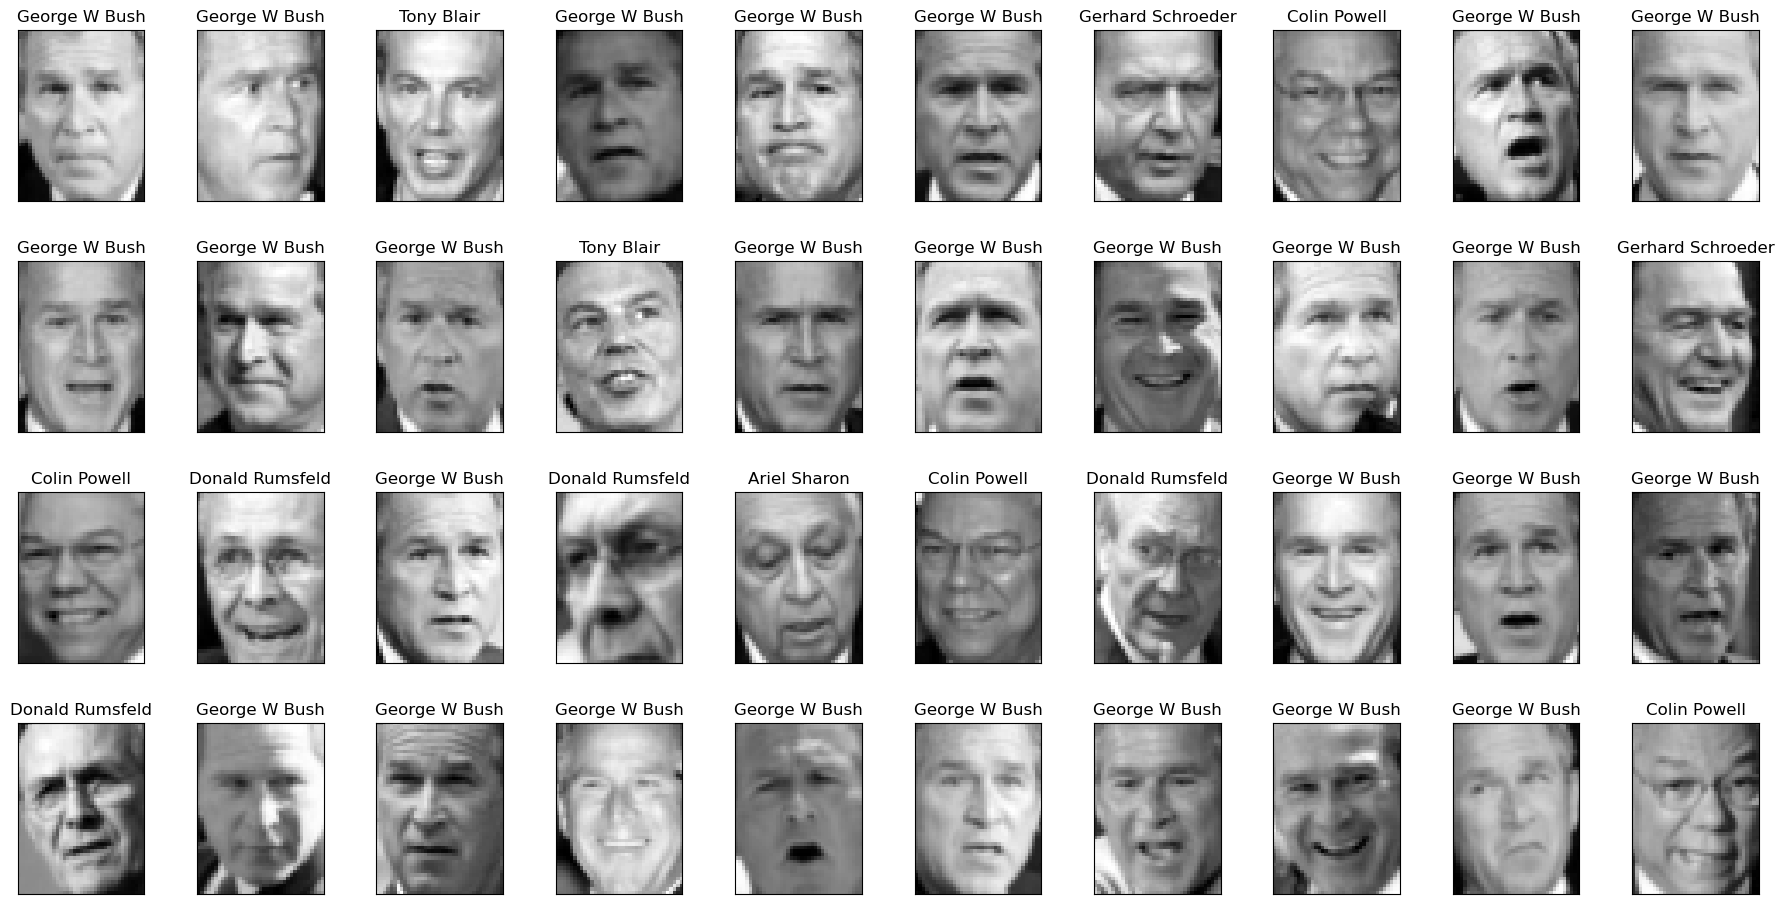

In [19]:
plot_gallery(X_test,target_names[y_test],h,w)

### Predicting

In [23]:
pred=model(torch.from_numpy(X_test_pca[19]).to(device))
target_names[torch.argmax(pred,-1).detach().cpu().numpy()]

'Gerhard Schroeder'